In [2]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl
import pandas as pd
import sys

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

In [3]:
import qcodes as qc
from qcodes import load_by_id
from qcodes.dataset.measurements import Measurement
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import Parameter

In [4]:
from pytopo.qctools.instruments import create_inst
from pytopo.qctools.dataset2 import select_experiment

from plottr import client
from plottr.qcodes_dataset import QcodesDatasetSubscriber

from pytopo.mplplots.init_nb_plotting import *

qc.config['core']['db_location'] = r"C:\Users\jowat\OneDrive\BF1\Data\experiments.db"

C:\Users\jowat\AppData\Local\Continuum\Anaconda3\envs\qcodes3\lib\site-packages\matplotlib\__init__.py:915: MatplotlibDeprecationWarning: nbagg.transparent is deprecated and ignored. Use figure.facecolor instead.
  mplDeprecation)


In [5]:
from plottr import client

In [6]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from scipy.integrate import cumtrapz
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
def mob_fit(x, a, b, c):
    return 1/(a + b/(x-c))

In [8]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [9]:
e = 1.602e-19
h = 6.63e-34
2*e**2/h

7.74179185520362e-05

In [10]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

## Mobility fitting

In [24]:
dv1 = qc.load_by_id(251)
dv2 = qc.load_by_id(252)

<IPython.core.display.Javascript object>


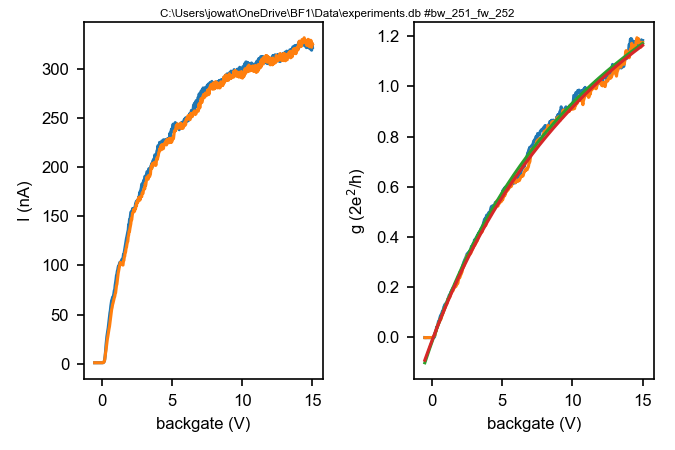

fw:  [  5.48030498e+03   8.26843213e+04   1.19651254e-01]
bw:  [  5.18909275e+03   8.81865236e+04   9.75163624e-02]


In [25]:
bg_fw = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
i1_fw = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g1_fw = np.array(dv1.get_values('ivvi_setup_g1_measurement'))[:,0]

bg_bw = np.array(dv2.get_data("ivvi_setup_dac6"))[:,0] 
i1_bw = np.array(dv2.get_values('ivvi_setup_i1_measurement'))[:,0]
g1_bw = np.array(dv2.get_values('ivvi_setup_g1_measurement'))[:,0]

popt_fw, pcov_fw = curve_fit(mob_fit, bg_fw[20:], g1_fw[20:]*(2*e**2/h))
popt_bw, pcov_bw = curve_fit(mob_fit, bg_bw[:-20], g1_bw[:-20]*(2*e**2/h))

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(bg_fw, i1_fw*1e9)
ax1.plot(bg_bw, i1_bw*1e9)
ax1.set_xlabel('backgate (V)')
ax1.set_ylabel('I (nA)')

ax2.plot(bg_fw, g1_fw)
ax2.plot(bg_bw, g1_bw)
ax2.plot(bg_fw, mob_fit(bg_fw, *popt_fw)/(2*e**2/h))
ax2.plot(bg_bw, mob_fit(bg_bw, *popt_bw)/(2*e**2/h))
ax2.set_xlabel('backgate (V)')
ax2.set_ylabel(r'g (2e$^2$/h)')

fig.suptitle(ds_title("bw_" + str(dv1.run_id) + "_fw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()


print("fw: ", popt_fw)
print("bw: ", popt_bw)

<IPython.core.display.Javascript object>


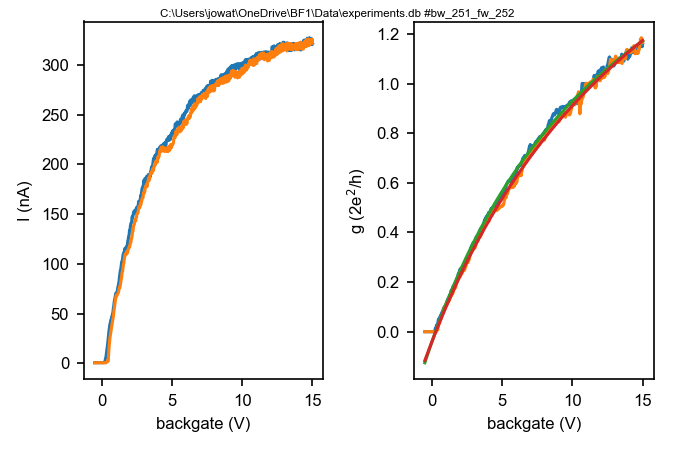

fw:  [  5.42486232e+03   8.25375163e+04   2.64734268e-01]
bw:  [  4.84431127e+03   9.06745295e+04   2.88938890e-01]


In [26]:
bg_fw = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
i2_fw = np.array(dv1.get_values('ivvi_setup_i2_measurement'))[:,0]
g2_fw = np.array(dv1.get_values('ivvi_setup_g2_measurement'))[:,0]

bg_bw = np.array(dv2.get_data("ivvi_setup_dac6"))[:,0] 
i2_bw = np.array(dv2.get_values('ivvi_setup_i2_measurement'))[:,0]
g2_bw = np.array(dv2.get_values('ivvi_setup_g2_measurement'))[:,0]

popt_fw, pcov_fw = curve_fit(mob_fit, bg_fw[20:], g2_fw[20:]*(2*e**2/h))
popt_bw, pcov_bw = curve_fit(mob_fit, bg_bw[:-20], g2_bw[:-20]*(2*e**2/h))

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(bg_fw, i2_fw*1e9)
ax1.plot(bg_bw, i2_bw*1e9)
ax1.set_xlabel('backgate (V)')
ax1.set_ylabel('I (nA)')

ax2.plot(bg_fw, g2_fw)
ax2.plot(bg_bw, g2_bw)
ax2.plot(bg_fw, mob_fit(bg_fw, *popt_fw)/(2*e**2/h))
ax2.plot(bg_bw, mob_fit(bg_bw, *popt_bw)/(2*e**2/h))
ax2.set_xlabel('backgate (V)')
ax2.set_ylabel(r'g (2e$^2$/h)')

fig.suptitle(ds_title("bw_" + str(dv1.run_id) + "_fw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()


print("fw: ", popt_fw)
print("bw: ", popt_bw)

<IPython.core.display.Javascript object>


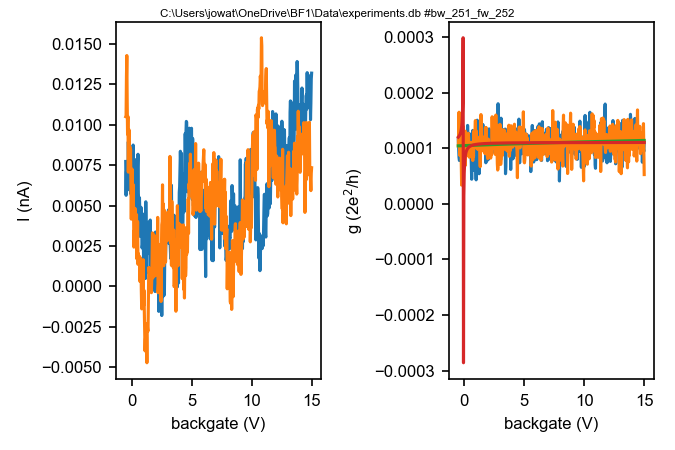

fw:  [  9.09438411e+07   1.09624648e+09  -3.35603376e+01]
bw:  [  1.16987064e+08   4.18926396e+06  -4.01647293e-02]


In [27]:
bg_fw = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
i3_fw = np.array(dv1.get_values('ivvi_setup_i3_measurement'))[:,0]
g3_fw = np.array(dv1.get_values('ivvi_setup_g3_measurement'))[:,0]

bg_bw = np.array(dv2.get_data("ivvi_setup_dac6"))[:,0] 
i3_bw = np.array(dv2.get_values('ivvi_setup_i3_measurement'))[:,0]
g3_bw = np.array(dv2.get_values('ivvi_setup_g3_measurement'))[:,0]

popt_fw, pcov_fw = curve_fit(mob_fit, bg_fw[20:], g3_fw[20:]*(2*e**2/h))
popt_bw, pcov_bw = curve_fit(mob_fit, bg_bw[:-20], g3_bw[:-20]*(2*e**2/h))

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(bg_fw, i3_fw*1e9)
ax1.plot(bg_bw, i3_bw*1e9)
ax1.set_xlabel('backgate (V)')
ax1.set_ylabel('I (nA)')

ax2.plot(bg_fw, g3_fw)
ax2.plot(bg_bw, g3_bw)
ax2.plot(bg_fw, mob_fit(bg_fw, *popt_fw)/(2*e**2/h))
ax2.plot(bg_bw, mob_fit(bg_bw, *popt_bw)/(2*e**2/h))
ax2.set_xlabel('backgate (V)')
ax2.set_ylabel(r'g (2e$^2$/h)')

fig.suptitle(ds_title("bw_" + str(dv1.run_id) + "_fw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()


print("fw: ", popt_fw)
print("bw: ", popt_bw)

In [28]:
L = 3e-6
C = 95e-18
a = np.array([9.62535231e04, 1.03273886e05,  8.39500765e04, 8.69609239e04, 8.21812594e04, 8.56998420e04, 8.102e4, 8.357e4, 8.948e4, 9.144e4, 7.975e4, 8.531e4, 8.26843217e+04, 8.81865226e+04,  8.25375162e+04, 9.06745301e+04])

mu = L**2/(a*C)

print(mu)

[ 0.98424285  0.91733589  1.12849024  1.08941853  1.15277915  1.10544944
  1.16930193  1.13362262  1.05874879  1.0360547   1.18792279  1.11050102
  1.14576549  1.07427801  1.1478034   1.04480103]


## Pinchoff curve overlays

In [29]:
dv1 = qc.load_by_id(295)
dv2 = qc.load_by_id(296)

<IPython.core.display.Javascript object>


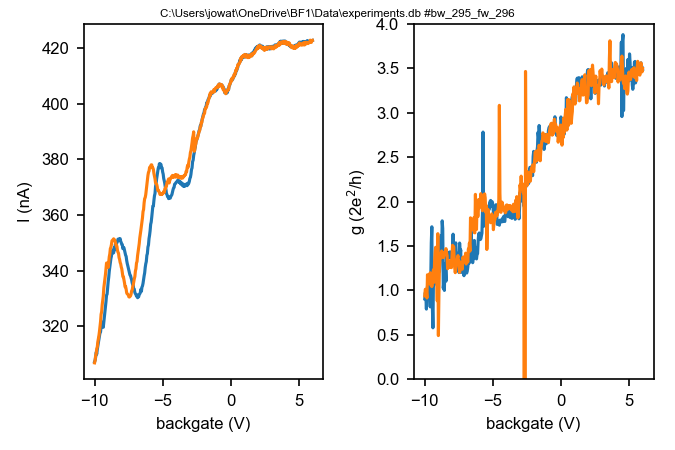

In [30]:
bg_fw = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
i_fw = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g_fw = np.array(dv1.get_values('ivvi_setup_g1_measurement'))[:,0]

bg_bw = np.array(dv2.get_data("ivvi_setup_dac6"))[:,0] 
i_bw = np.array(dv2.get_values('ivvi_setup_i1_measurement'))[:,0]
g_bw = np.array(dv2.get_values('ivvi_setup_g1_measurement'))[:,0]

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(bg_fw, i_fw*1e9)
ax1.plot(bg_bw, i_bw*1e9)
ax1.set_xlabel('backgate (V)')
ax1.set_ylabel('I (nA)')

ax2.plot(bg_fw, g_fw)
ax2.plot(bg_bw, g_bw)
ax2.set_xlabel('backgate (V)')
ax2.set_ylabel(r'g (2e$^2$/h)')
#ax2.set_xlim([-4, 0])
ax2.set_ylim([0,4])

fig.suptitle(ds_title("bw_" + str(dv1.run_id) + "_fw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()

In [31]:
bg_fw = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
i_fw = np.array(dv1.get_values('ivvi_setup_i2_measurement'))[:,0]
g_fw = np.array(dv1.get_values('ivvi_setup_g2_measurement'))[:,0]

bg_bw = np.array(dv2.get_data("ivvi_setup_dac6"))[:,0] 
i_bw = np.array(dv2.get_values('ivvi_setup_i2_measurement'))[:,0]
g_bw = np.array(dv2.get_values('ivvi_setup_g2_measurement'))[:,0]

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(bg_fw, i_fw*1e9)
ax1.plot(bg_bw, i_bw*1e9)
ax1.set_xlabel('backgate (V)')
ax1.set_ylabel('I (nA)')

ax2.plot(bg_fw, g_fw)
ax2.plot(bg_bw, g_bw)
ax2.set_xlabel('backgate (V)')
ax2.set_ylabel(r'g (2e$^2$/h)')
#ax2.set_xlim([-10, -8])
#ax2.set_ylim([0,4])

fig.suptitle(ds_title("bw_" + str(dv1.run_id) + "_fw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()

ValueError: Unknown parameter, not in this DataSet

In [32]:
bg_fw = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
i_fw = np.array(dv1.get_values('ivvi_setup_i3_measurement'))[:,0]
g_fw = np.array(dv1.get_values('ivvi_setup_g3_measurement'))[:,0]

bg_bw = np.array(dv2.get_data("ivvi_setup_dac6"))[:,0] 
i_bw = np.array(dv2.get_values('ivvi_setup_i3_measurement'))[:,0]
g_bw = np.array(dv2.get_values('ivvi_setup_g3_measurement'))[:,0]

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(bg_fw, i_fw*1e9)
ax1.plot(bg_bw, i_bw*1e9)
ax1.set_xlabel('backgate (V)')
ax1.set_ylabel('I (nA)')

ax2.plot(bg_fw, g_fw)
ax2.plot(bg_bw, g_bw)
ax2.set_xlabel('backgate (V)')
ax2.set_ylabel(r'g (2e$^2$/h)')
ax2.set_ylim([0,10])

fig.suptitle(ds_title("bw_" + str(dv1.run_id) + "_fw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()

ValueError: Unknown parameter, not in this DataSet

## 2D plotting plus linecuts

<IPython.core.display.Javascript object>


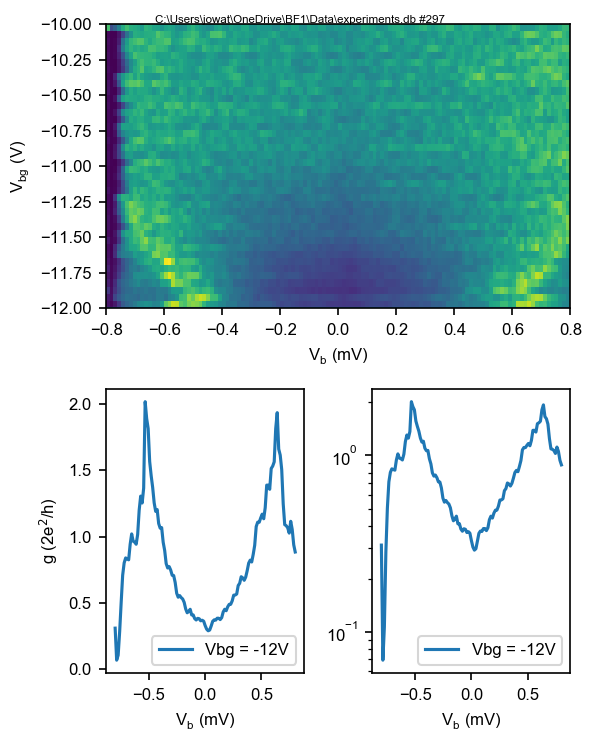

In [33]:
dv1 = qc.load_by_id(297)

bg = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
bias = np.array(dv1.get_data("ivvi_setup_dac5"))[:,0] 
i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g1_measurement'))[:,0]



bg = np.unique(bg)
bg = np.flip(bg, 0)
bias= np.unique(bias)

n_lines = bg.size
g = g[0:n_lines*121]

g = g.reshape(n_lines, bias.size)

fig = plt.figure(figsize=(4,5))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

bg_cut = -12
bg_cut_idx = np.argmin(abs(bg - bg_cut))
n_cut = 40

p = ax1.pcolor(bias*1e3, bg[0:n_lines], g)
ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"$\mathregular{V_{bg}}$ (V)")
ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")


ax2.plot(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax2.set_ylabel(r'g (2e$^2$/h)')
ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax2.legend()
# ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
fig.tight_layout()

# fig.savefig("d:/data/images/gap_dev14.png", dpi=300)

In [ ]:
np.linalg.norm([1,1,1.3])

In [ ]:
Br = 2
theta = 17
phi = 90

Bx = Br*np.sin(theta*np.pi/180)*np.cos(phi*np.pi/180)
By = Br*np.sin(theta*np.pi/180)*np.sin(phi*np.pi/180)
Bz = Br*np.cos(theta*np.pi/180)
print('Bx = ' + str(Bx) + ' T')
print('By = ' + str(By) + ' T')
print('Bz = ' + str(Bz) + ' T')

## Numerical dV/dI - 2D plots

In [34]:
dv1 = qc.load_by_id(338)
dv1

results #338@C:\Users\jowat\OneDrive\BF1\Data\experiments.db
------------------------------------------------------------
ivvi_setup_dac4 - numeric
ivvi_setup_dac6 - numeric
ivvi_setup_v1_measurement - numeric
ivvi_setup_v2_measurement - numeric
ivvi_setup_r_ac1_measurement - numeric
ivvi_setup_r_ac2_measurement - numeric

In [35]:
Nsmooth = 3 #Number of points to use for adjacent average smoothing 
bg = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
Ibias = np.array(dv1.get_data("ivvi_setup_dac4"))[:,0] 
v = np.array(dv1.get_values('ivvi_setup_v1_measurement'))[:,0]
dvdi = np.array(dv1.get_values('ivvi_setup_r_ac2_measurement'))[:,0]



bg = np.unique(bg)
bg = np.flip(bg, 0)
Ibias= np.unique(Ibias)

n_lines = bg.size - 1
dvdi = dvdi[0:n_lines*Ibias.size]
dvdi = dvdi.reshape(n_lines, Ibias.size)

#pd.rolling_mean(x, N)[N-1:]
dvdi_smooth = pd.rolling_mean(dvdi, Nsmooth)[Nsmooth-1:]
fig = plt.figure(figsize=(4,4))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
#ax3 = plt.subplot(224)

bg_cut = 9.625
bg_cut_idx = np.argmin(abs(bg - bg_cut))
bg_cut = bg[bg_cut_idx]

p = ax1.pcolor(Ibias, bg[0:n_lines], dvdi)
ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"$\mathregular{V_{bg}}$ (V)")
ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")


ax2.plot(Ibias/1e-9, dvdi[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax2.plot(Ibias/1e-9, dvdi_smooth[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax2.set_ylabel(r'dV/dI ($\Omega$)')
ax2.set_xlabel(r"$\mathregular{I_b}$ (nA)")
ax2.legend()
# ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

#ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
#ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
#ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
fig.tight_layout()

# fig.savefig("d:/data/images/gap_dev14.png", dpi=300)

AttributeError: module 'pandas' has no attribute 'rolling_mean'

In [36]:
%matplotlib notebook
Nsmooth = 3 #Number of points to use for adjacent average smoothing 
bg = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
Ibias = np.array(dv1.get_data("ivvi_setup_dac4"))[:,0] 
v = np.array(dv1.get_values('ivvi_setup_v1_measurement'))[:,0]
dvdi = np.array(dv1.get_values('ivvi_setup_r_ac2_measurement'))[:,0]



bg = np.unique(bg)
bg = np.flip(bg, 0)
Ibias= np.unique(Ibias)

n_lines = bg.size - 1
dvdi = dvdi[0:n_lines*Ibias.size]
dvdi = dvdi.reshape(n_lines, Ibias.size)

#pd.rolling_mean(x, N)[N-1:]
dvdi_smooth = pd.rolling_mean(dvdi, Nsmooth)[Nsmooth-1:]
#fig = plt.figure(figsize=(4,4))

#ax1 = plt.subplot(211)
#ax2 = plt.subplot(212)
#ax3 = plt.subplot(224)

bg_cut = 9.625
bg_cut_idx = np.argmin(abs(bg - bg_cut))
bg_cut = bg[bg_cut_idx]


#f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

#ax1.pcolormesh(Ibias, bg[0:n_lines], dvdi)
#ax2.plot(Ibias/1e-9, dvdi[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
#f.show()



# p = ax1.pcolor(Ibias, bg[0:n_lines], dvdi)
# ax1.axhline(y=bg_cut)
# ax1.set_ylabel(r"$\mathregular{V_{bg}}$ (V)")
# ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")


# ax2.plot(Ibias/1e-9, dvdi[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax2.plot(Ibias/1e-9, dvdi_smooth[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax2.set_ylabel(r'dV/dI ($\Omega$)')
# ax2.set_xlabel(r"$\mathregular{I_b}$ (nA)")
# ax2.legend()
# # ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

# #ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# #ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# #ax3.legend()

# fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
# fig.tight_layout()

# # fig.savefig("d:/data/images/gap_dev14.png", dpi=300)

AttributeError: module 'pandas' has no attribute 'rolling_mean'

In [ ]:
Nsmooth_x = 5 #1 = no smoothing
Nsmooth_y = 3
#pd.rolling_mean(x, N)[N-1:]

dvdi_smooth = np.ones(np.shape(dvdi))
for i in range(n_lines):
    dvdi_smooth[i,:] = smooth(dvdi[i,:], Nsmooth_x)
    
dvdi_smoothy = np.ones(np.shape(dvdi))
for i in range(Ibias.size):
    dvdi_smoothy[:,i] = smooth(dvdi_smooth[:,i], Nsmooth_y)


fig = plt.figure(figsize=(4,4))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
#ax3 = plt.subplot(224)

bg_cut = 9.625
bg_cut_idx = np.argmin(abs(bg - bg_cut))
bg_cut = bg[bg_cut_idx]

p = ax1.pcolor(Ibias, bg[0:n_lines], dvdi_smooth)
ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"$\mathregular{V_{bg}}$ (V)")
ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")


ax2.plot(Ibias/1e-9, dvdi[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax2.plot(Ibias/1e-9, dvdi_smooth[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax2.set_ylabel(r'dV/dI ($\Omega$)')
ax2.set_xlabel(r"$\mathregular{I_b}$ (nA)")
ax2.legend()
# ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

#ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
#ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
#ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
fig.tight_layout()

In [21]:
dv1 = qc.load_by_id(345)
dv1

results #345@C:\Users\jowat\OneDrive\BF1\Data\experiments.db
------------------------------------------------------------
ivvi_setup_dac4 - numeric
AMI430_field - numeric
ivvi_setup_v1_measurement - numeric
ivvi_setup_v2_measurement - numeric
ivvi_setup_r_ac1_measurement - numeric
ivvi_setup_r_ac2_measurement - numeric

<IPython.core.display.Javascript object>


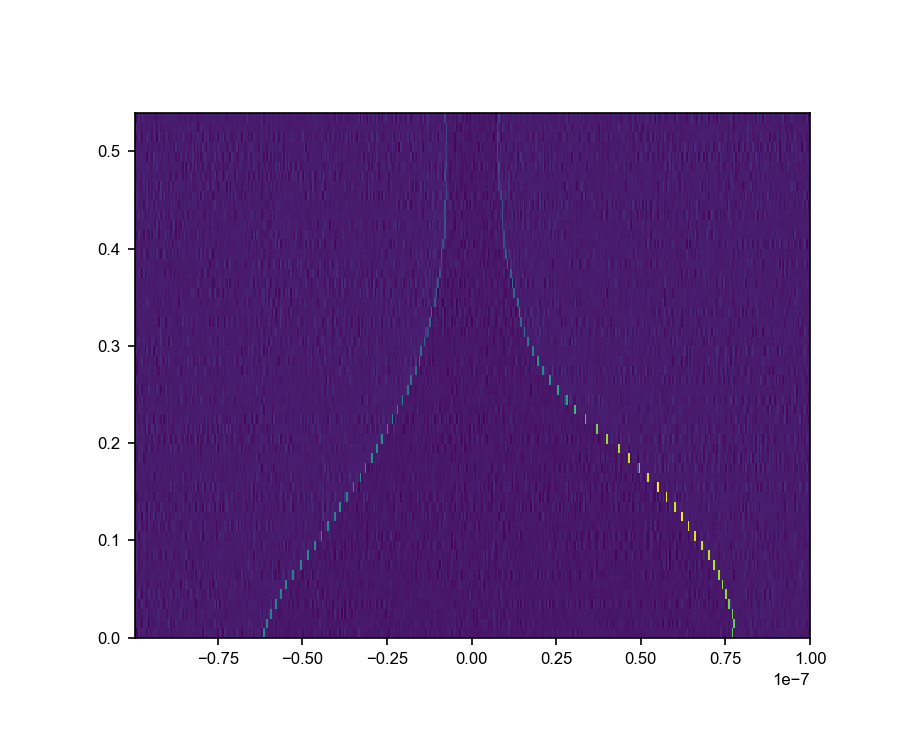

In [22]:
field = np.array(dv1.get_data("AMI430_field"))[:,0] 
Ibias = np.array(dv1.get_data("ivvi_setup_dac4"))[:,0] 
v     = np.array(dv1.get_values('ivvi_setup_v2_measurement'))[:,0]
dvdi  = np.array(dv1.get_values('ivvi_setup_r_ac2_measurement'))[:,0]



field = np.unique(field)
# bg = np.flip(bg, 0)
Ibias= np.unique(Ibias)

n_lines = field.size
n_lines = 55
v = v[0:n_lines*Ibias.size]

v = v.reshape(n_lines, Ibias.size)

# y_cut = 21
# y_cut_idx = np.argmin(abs(field - y_cut))
# y_cut = field[y_cut_idx]

fig, ax1 = plt.subplots(1,1, figsize=(6,5))

# ax2 = plt.subplot(223)
# ax3 = plt.subplot(224)

ax1.pcolor(Ibias[1::], field[0:n_lines], np.diff(v,1))
# ax1.axhline(y=y_cut)


# bg_cut = -12
# bg_cut_idx = np.argmin(abs(bg - bg_cut))
# n_cut = 40

In [23]:
theta = np.array(dv1.get_data("AMI430_theta"))[:,0] 
Ibias = np.array(dv1.get_data("ivvi_setup_dac4"))[:,0] 
v     = np.array(dv1.get_values('ivvi_setup_v1_measurement'))[:,0]
dvdi  = np.array(dv1.get_values('ivvi_setup_r_ac1_measurement'))[:,0]



theta = np.unique(theta)
# bg = np.flip(bg, 0)
Ibias= np.unique(Ibias)

# n_lines = theta.size
# n_lines = 3
v = v[0:n_lines*Ibias.size]

v = v.reshape(n_lines, Ibias.size)

fig, ax1 = plt.subplots(1,1, figsize=(6,5))

ax1.pcolor(Ibias[1::], theta[0:n_lines], np.diff(v,1))

# bg_cut = -12
# bg_cut_idx = np.argmin(abs(bg - bg_cut))
# n_cut = 40

ERROR:root:Could not execute transaction, rolling back
Traceback (most recent call last):
  File "C:\Users\jowat\Lab_Code\Qcodes\qcodes\dataset\sqlite_base.py", line 254, in atomic_transaction
    c = transaction(conn, sql, *args)
  File "C:\Users\jowat\Lab_Code\Qcodes\qcodes\dataset\sqlite_base.py", line 233, in transaction
    c.execute(sql)
sqlite3.OperationalError: no such column: AMI430_theta


OperationalError: no such column: AMI430_theta

# dI/dV with corrected sample bias
Plot dI/dB with corrected bias axis to account for voltage drop across the filters

In [37]:
dv1 = qc.load_by_id(276)
dv1

results #276@C:\Users\jowat\OneDrive\BF1\Data\experiments.db
------------------------------------------------------------
ivvi_setup_dac6 - numeric
ivvi_setup_dac5 - numeric
ivvi_setup_i1_measurement - numeric
ivvi_setup_i2_measurement - numeric
ivvi_setup_i3_measurement - numeric
ivvi_setup_ig_measurement - numeric
ivvi_setup_g1_measurement - numeric
ivvi_setup_g2_measurement - numeric
ivvi_setup_g3_measurement - numeric

<IPython.core.display.Javascript object>


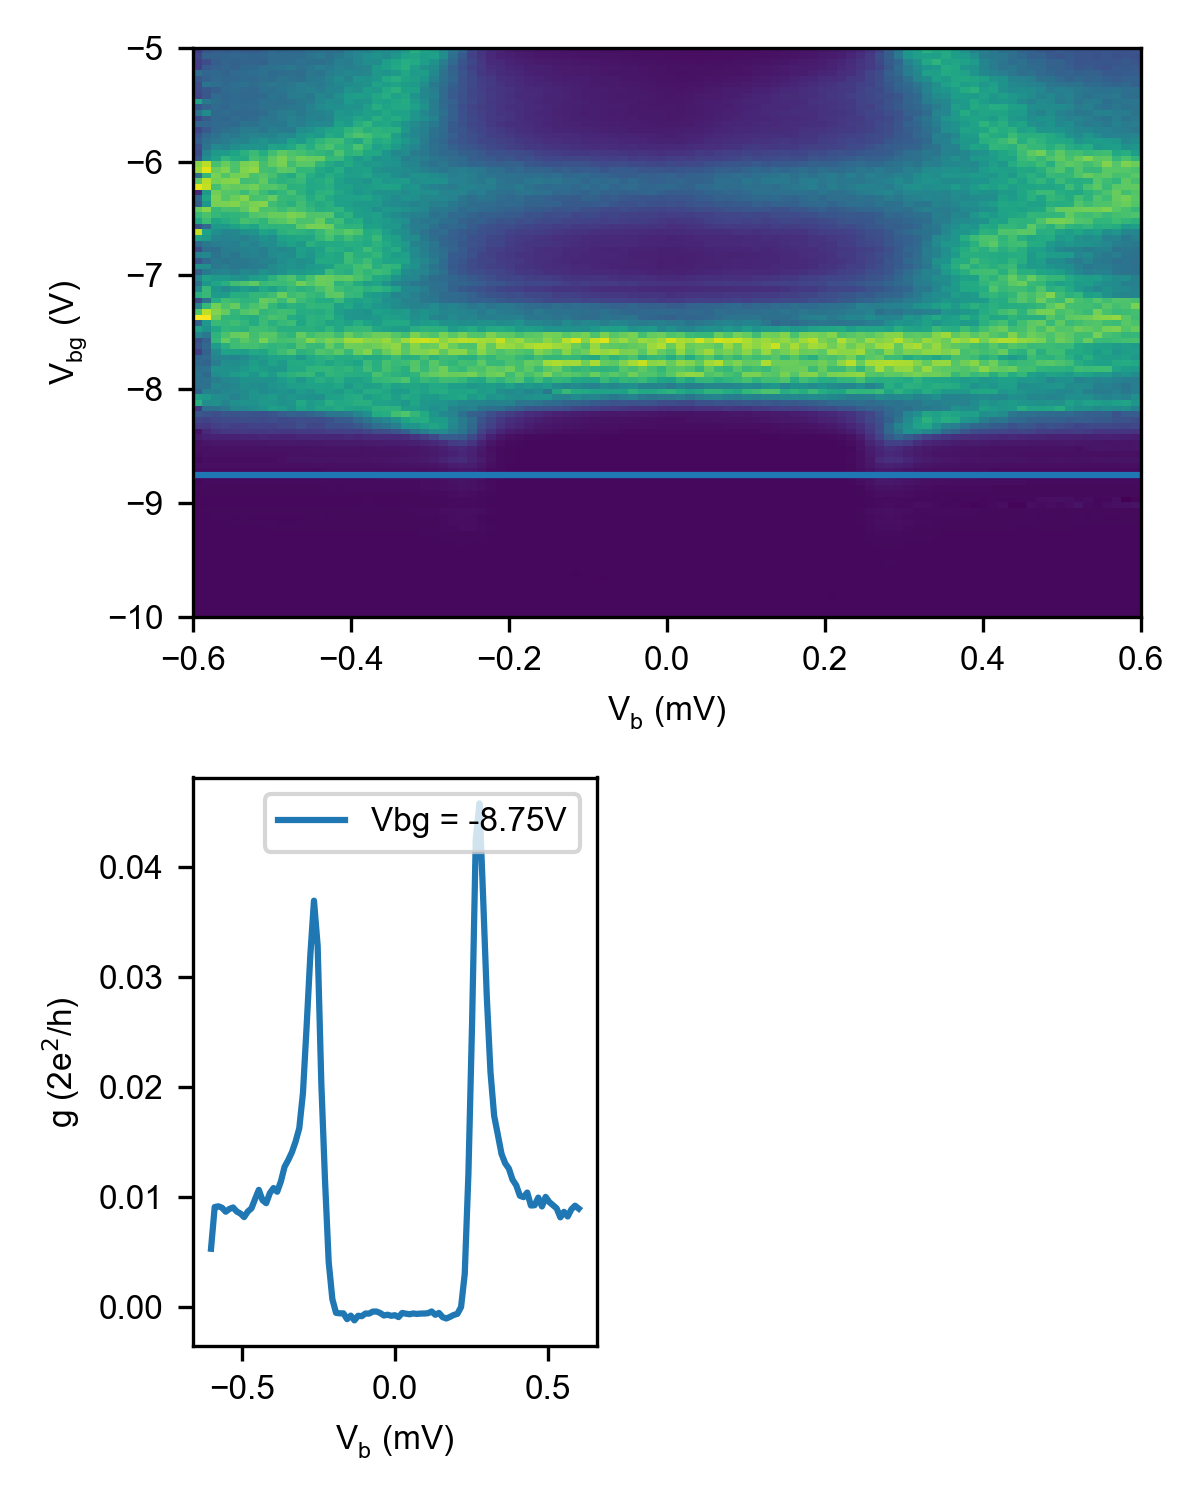

In [92]:
bg = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
bias = np.array(dv1.get_data("ivvi_setup_dac5"))[:,0] 
i = np.array(dv1.get_values('ivvi_setup_i2_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g2_measurement'))[:,0]



bg = np.unique(bg)
bg = np.flip(bg, 0)
bias= np.unique(bias)


#bias_corrected = 
n_lines = bg.size
g = g[0:n_lines*121]

g = g.reshape(n_lines, bias.size)

fig = plt.figure(figsize=(4,5))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

bg_cut = -8.75
bg_cut_idx = np.argmin(abs(bg - bg_cut))
n_cut = 40

p = ax1.pcolor(bias*1e3, bg[0:n_lines], g)
ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"$\mathregular{V_{bg}}$ (V)")
ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")


ax2.plot(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax2.set_ylabel(r'g (2e$^2$/h)')
ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax2.legend()
# ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
fig.tight_layout()

# fig.savefig("d:/data/images/gap_dev14.png", dpi=300)

In [46]:
np.shape(x2)

(9,)

In [42]:
dv1 = qc.load_by_id(261)
dv1

results #261@C:\Users\jowat\OneDrive\BF1\Data\experiments.db
------------------------------------------------------------
ivvi_setup_dac6 - numeric
ivvi_setup_dac5 - numeric
ivvi_setup_i1_measurement - numeric
ivvi_setup_i2_measurement - numeric
ivvi_setup_i3_measurement - numeric
ivvi_setup_ig_measurement - numeric
ivvi_setup_g1_measurement - numeric
ivvi_setup_g2_measurement - numeric
ivvi_setup_g3_measurement - numeric

<IPython.core.display.Javascript object>


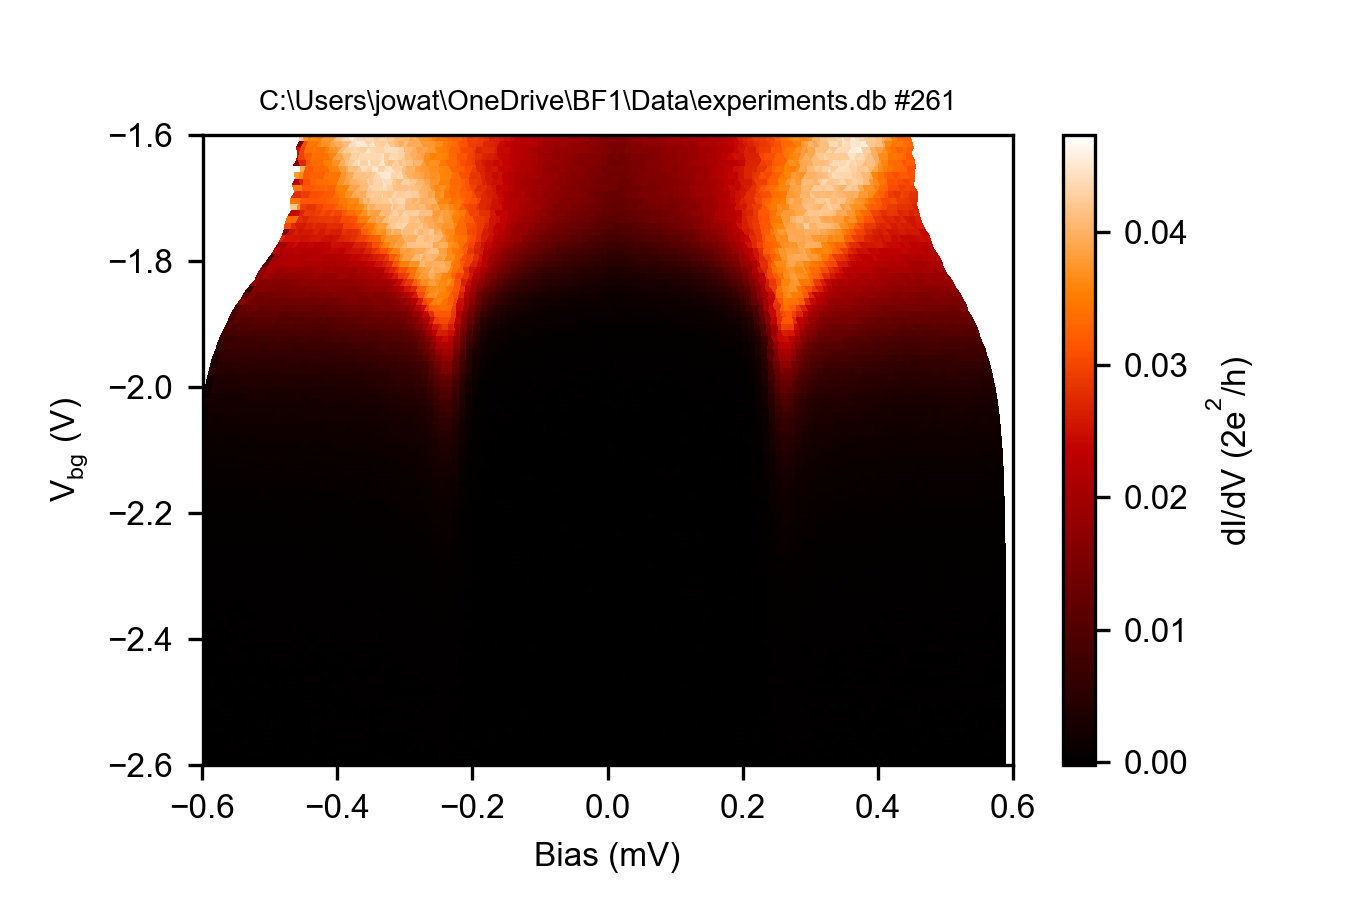

Text(0.5,1,'C:\\Users\\jowat\\OneDrive\\BF1\\Data\\experiments.db #261')

In [46]:
Rseries = 10e3


bg = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
bias = np.array(dv1.get_data("ivvi_setup_dac5"))[:,0] 
current = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g1_measurement'))[:,0]

bg = np.unique(bg)
bg = np.flip(bg, 0)
bias= np.unique(bias)


#bias_corrected = 
n_lines = bg.size


g = g.reshape(n_lines, bias.size)
current = current.reshape(n_lines, bias.size)

bias_corrected = np.empty(np.shape(g))
for i in range(np.shape(bias_corrected)[0]):
    for j in range(np.shape(bias_corrected)[1]):
        bias_corrected[i,j] = bias[j] - current[i,j]*Rseries

plt.pcolor(bias_corrected/1e-3, bg, g, cmap='gist_heat')
plt.xlabel('Bias (mV)')
plt.ylabel(r"$\mathregular{V_{bg}}$ (V)")
plt.xlim([np.min(bias)/1e-3,np.max(bias)/1e-3])
plt.colorbar(label=r"dI/dV ($\mathregular{2e^2/h}$) ")
plt.title(ds_title(str(dv1.run_id)), size='small')

In [31]:
mpl.cm.G



In [74]:
n_lines

101